<a href="https://colab.research.google.com/github/JichenSong666/mmai894/blob/JichenSong/Crack_Detection_0318_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading

**Download ZIP files and unzip into Colab environment**

In [1]:
# Download training/validation data file (40000 concrete images with and without cracks)
!wget https://www.josephambrose.com/concrete_data.zip

--2021-04-03 19:36:49--  https://www.josephambrose.com/concrete_data.zip
Resolving www.josephambrose.com (www.josephambrose.com)... 64.37.52.52
Connecting to www.josephambrose.com (www.josephambrose.com)|64.37.52.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243982265 (233M) [application/zip]
Saving to: ‘concrete_data.zip’

concrete_data.zip   100%[===================>] 232.68M   888KB/s    in 4m 12s  

2021-04-03 19:41:04 (945 KB/s) - ‘concrete_data.zip’ saved [243982265/243982265]



In [10]:
# Download testing data file (56000 images of pavements, decks, and walls with and without cracks)
!wget https://www.josephambrose.com/SDNET.zip

--2021-04-03 19:43:27--  https://www.josephambrose.com/SDNET.zip
Resolving www.josephambrose.com (www.josephambrose.com)... 64.37.52.52
Connecting to www.josephambrose.com (www.josephambrose.com)|64.37.52.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 528256823 (504M) [application/zip]
Saving to: ‘SDNET.zip’

SDNET.zip           100%[===================>] 503.78M   934KB/s    in 9m 37s  

2021-04-03 19:53:06 (894 KB/s) - ‘SDNET.zip’ saved [528256823/528256823]



In [11]:
import os
!unzip -q concrete_data.zip
!unzip -q SDNET.zip
print(os.listdir())

replace concrete_data/negative/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
['.config', 'training', 'SDNET', 'validation', 'SDNET.zip', 'concrete_data.zip', 'concrete_data', 'sample_data']


##Data Visualization

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

negative_images = sorted(os.listdir('concrete_data/negative'))[0:]
print("Negative images (n =",len(negative_images), "):", negative_images[:10])

positive_images = sorted(os.listdir('concrete_data/positive'))[0:]
print("Positive images (n =",len(positive_images), "):", positive_images[:10])

print('Each image has the following shape: ',end='')
np.array(Image.open(f'concrete_data/positive/{positive_images[10]}')).shape

Negative images (n = 20000 ): ['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg']
Positive images (n = 20000 ): ['00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg']
Each image has the following shape: 

(227, 227, 3)

**Images with Crack**

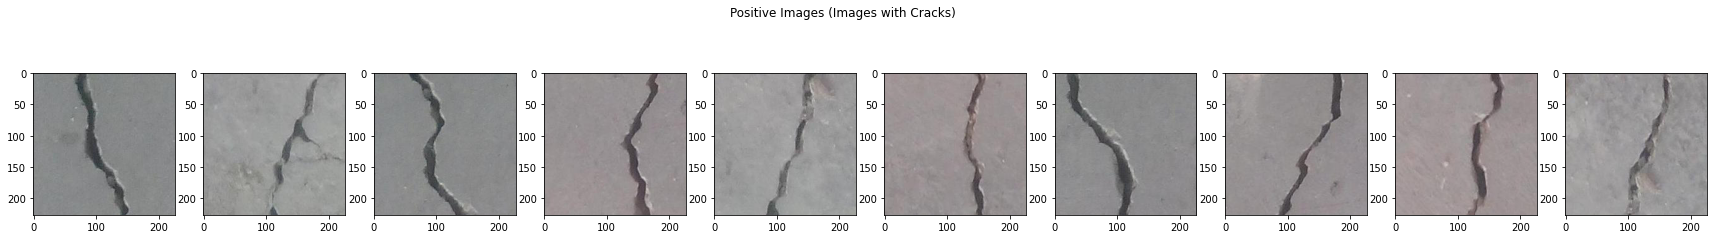

In [13]:
figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = 0
for current_position in position:
    image_data = Image.open(f'concrete_data/positive/{positive_images[index]}')
    current_position.imshow(image_data)
    index = index + 1
figure.suptitle('Positive Images (Images with Cracks)') 
plt.show()

**Images without Crack**

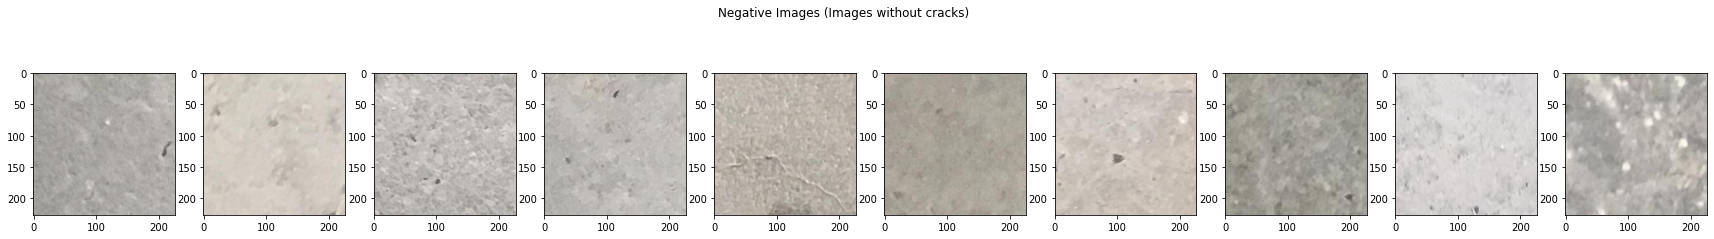

In [14]:
figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = 0
for current_position in position:
    image_data = Image.open(f'concrete_data/negative/{negative_images[index]}')
    current_position.imshow(image_data)
    index = index + 1
figure.suptitle('Negative Images (Images without cracks)') 
plt.show()


**Creating training and validation folders with image files**




In [15]:
import shutil
def create_folder(folder_name):
    if os.path.exists(folder_name):
       shutil.rmtree(folder_name)
    os.makedirs(folder_name)

# create training and validation folders
create_folder("training/negative")
create_folder("training/positive")
create_folder("validation/negative")
create_folder("validation/positive")

# obtain root directory
root_directory = os.getcwd()
#print(os.listdir(root_directory))

# defining four folders
training_negative = root_directory + "/training/negative/"
training_positive = root_directory + "/training/positive/"
validation_negative = root_directory + "/validation/negative/"
validation_positive = root_directory + "/validation/positive/"

# randomly allocate 80% of images into training set, and 20% into validation set
# copy images into appropriate folders
import random
random.seed(2021)
for f in positive_images:
    if random.random() > 0.80:
        shutil.copy(f'concrete_data/positive/{f}', validation_positive)
    else:
        shutil.copy(f'concrete_data/positive/{f}', training_positive)

for f in negative_images:
    if random.random() > 0.80:
        shutil.copy(f'concrete_data/negative/{f}', validation_negative)
    else:
        shutil.copy(f'concrete_data/negative/{f}', training_negative)

**Loading training and validation sets with images (from reading files)**

---



In [16]:
num_classes = 2
image_resize = 227 
training_batch_size = 100
validation_batch_size = 100

num_epochs = 1 # Number of epochs to train the subsequent models

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

def create_data_generator_set(folder, batch_size):
    data_generator_set = data_generator.flow_from_directory(folder, target_size=(image_resize, image_resize), batch_size=batch_size, class_mode='categorical')
    return data_generator_set

print("Training set:")
train_data = create_data_generator_set(root_directory+'/training', training_batch_size)
print("Validation set:")
validation_data = create_data_generator_set(root_directory+'/validation', validation_batch_size)

Training set:
Found 31998 images belonging to 2 classes.
Validation set:
Found 8002 images belonging to 2 classes.


**Creating 3 testing sets (Decks, Pavements, Walls)**

In [17]:
testing_batch_size = 100
print("Testing sets:")
test_data_Decks = create_data_generator_set(root_directory+'/SDNET/Decks', testing_batch_size)
test_data_Pavements = create_data_generator_set(root_directory+'/SDNET/Pavements', testing_batch_size)
test_data_Walls = create_data_generator_set(root_directory+'/SDNET/Walls', testing_batch_size)

Testing sets:
Found 13620 images belonging to 2 classes.
Found 24334 images belonging to 2 classes.
Found 18138 images belonging to 2 classes.


## Visualization of SDNET images##

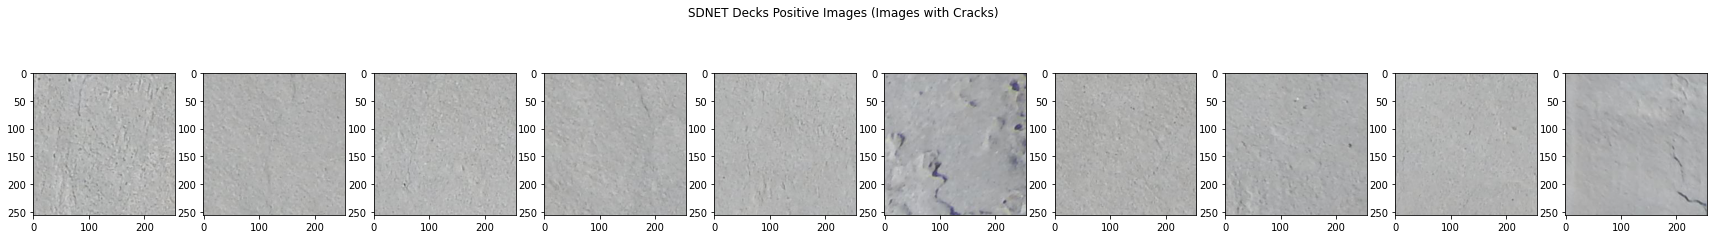

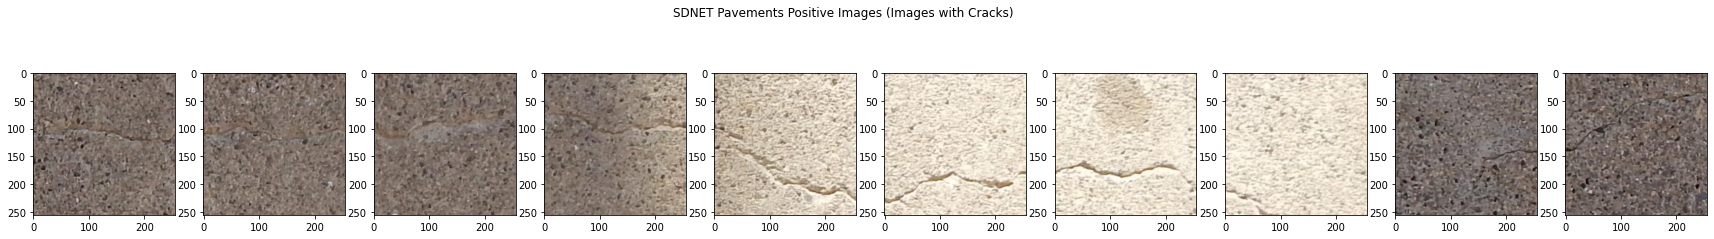

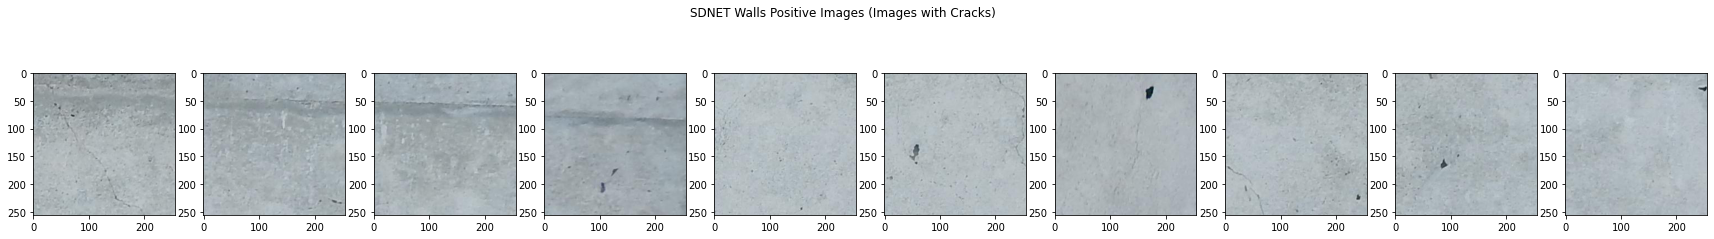

In [18]:
positive_images = sorted(os.listdir('SDNET/Decks/positive'))[0:]
figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = 0
for current_position in position:
    image_data = Image.open(f'SDNET/Decks/positive/{positive_images[index]}')
    current_position.imshow(image_data)
    index = index + 1
figure.suptitle('SDNET Decks Positive Images (Images with Cracks)') 
plt.show()

positive_images = sorted(os.listdir('SDNET/Pavements/positive'))[0:]
figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = 0
for current_position in position:
    image_data = Image.open(f'SDNET/Pavements/positive/{positive_images[index]}')
    current_position.imshow(image_data)
    index = index + 1
figure.suptitle('SDNET Pavements Positive Images (Images with Cracks)') 
plt.show()

positive_images = sorted(os.listdir('SDNET/Walls/positive'))[0:]
figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = 0
for current_position in position:
    image_data = Image.open(f'SDNET/Walls/positive/{positive_images[index]}')
    current_position.imshow(image_data)
    index = index + 1
figure.suptitle('SDNET Walls Positive Images (Images with Cracks)') 
plt.show()

## CNN model ##

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_resize,image_resize,3)))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))
cnn1.add(Flatten())
cnn1.add(Dense(32, activation='relu'))
cnn1.add(Dense(num_classes, activation='softmax'))
cnn1.summary()

cnn1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


cnn1_fit_history = cnn1.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                12845088  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 12,846,050
Trainable params: 12,846,050
Non-trainable params: 0
____________________________________________

## VGG16 pre-trained model ##

In [20]:
from keras.applications.vgg16 import VGG16
vgg16 = Sequential()
vgg16.add(VGG16(include_top=False, pooling='max', weights='imagenet'))
vgg16.add(Dense(10,activation='relu'))
vgg16.add(Dense(num_classes, activation='softmax'))
vgg16.layers[0].trainable = False
vgg16.summary()

vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_fit_history = vgg16.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 14,719,840
Trainable params: 5,152
Non-trainable params: 14,714,688
_________________________________________________________________
320/320 [==============================] - 220s 637ms/step - loss: 0.0917 - accuracy: 0.9753 - val_loss: 0.0133 - val_accuracy: 0.9956


## ResNet50 pre-trained model ##

In [21]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Input
resnet = Sequential()
resnet.add(ResNet50(include_top=False, pooling='max', weights='imagenet', input_tensor=Input(shape=(image_resize, image_resize, 3))))
resnet.add(Dense(10,activation='relu'))
resnet.add(Dense(num_classes, activation='softmax'))
resnet.layers[0].trainable = False
resnet.summary()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


resnet_fit_history = resnet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 23,608,224
Trainable params: 20,512
Non-trainable params: 23,587,712
_________________________________________________________________
320/320 [==============================] - 157s 478ms/step - loss: 0.1028 - accuracy: 0.9710 - val_loss: 0.0065 - val_accuracy: 0.9979


##NASNetLarge model##

In [22]:
from keras.applications import NASNetLarge
from keras.layers import Input
nasnet = Sequential()
nasnet.add(NASNetLarge(include_top=False, pooling='max', weights='imagenet', input_tensor=Input(shape=(image_resize, image_resize, 3))))
nasnet.add(Dense(10,activation='relu'))
nasnet.add(Dense(num_classes, activation='softmax'))
nasnet.layers[0].trainable = False
nasnet.summary()

nasnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


nasnet_fit_history = nasnet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)

343613440/343610240 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 4032)              84916818  
_________________________________________________________________
dense_6 (Dense)              (None, 10)                40330     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 22        
Total params: 84,957,170
Trainable params: 40,352
Non-trainable params: 84,916,818
_________________________________________________________________
320/320 [==============================] - 555s 2s/step - loss: 0.5121 - accuracy: 0.9050 - val_loss: 0.0625 - val_accuracy: 0.9770


## DenseNet model ##

In [23]:
from keras.applications import DenseNet201
from keras.layers import Input

densenet = Sequential()
densenet.add(DenseNet201(include_top=False, pooling='max', weights='imagenet', input_tensor=Input(shape=(image_resize, image_resize, 3))))
densenet.add(Dense(10,activation='relu'))
densenet.add(Dense(num_classes, activation='softmax'))
densenet.layers[0].trainable = False
densenet.summary()

densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

densenet_fit_history = densenet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_8 (Dense)              (None, 10)                19210     
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 22        
Total params: 18,341,216
Trainable params: 19,232
Non-trainable params: 18,321,984
_________________________________________________________________
320/320 [==============================] - 204s 594ms/step - loss: 0.1069 - accuracy: 0.9635 - val_loss: 0.0148 - val_accuracy: 0.9960


##YoLo Model

In [ ]:
'''
# import the necesasry packages: 

import cv2
import matplotlib.pyplot as plt
!pip install utils
from utils import *
from darknet import Darknet

'''

In [ ]:
'''
#YOLO V3: 

# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0

# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')


'''

## Testing all models using SDNET data ##

**Create model testing function that produces confusion matrix and performance metrics**

In [24]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import numpy
def model_testing(model, dataset):
    predictions = model.predict(dataset)
    predicted_classes = numpy.argmax(predictions, axis=1)
    true_classes = dataset.classes
    labels_for_classes = list(dataset.class_indices.keys())  
    matrix = confusion_matrix(true_classes, predicted_classes)
    report = classification_report(true_classes, predicted_classes, target_names=labels_for_classes) 
    return matrix, report

def model_testing_three_datasets(model):
    print(list(test_data_Decks.class_indices.keys()))
    matrix, report = model_testing(model, test_data_Decks)
    print("Decks:\n", matrix, "\n", report)
    matrix, report = model_testing(model, test_data_Pavements)
    print("Pavements:\n", matrix, "\n", report)
    matrix, report = model_testing(model, test_data_Walls)
    print("Walls:\n", matrix, "\n", report)

**Testing CNN model performance**

In [25]:
model_testing_three_datasets(cnn1)

['negative', 'positive']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decks:
 [[11595     0]
 [ 2025     0]] 
               precision    recall  f1-score   support

    negative       0.85      1.00      0.92     11595
    positive       0.00      0.00      0.00      2025

    accuracy                           0.85     13620
   macro avg       0.43      0.50      0.46     13620
weighted avg       0.72      0.85      0.78     13620

Pavements:
 [[21726     0]
 [ 2608     0]] 
               precision    recall  f1-score   support

    negative       0.89      1.00      0.94     21726
    positive       0.00      0.00      0.00      2608

    accuracy                           0.89     24334
   macro avg       0.45      0.50      0.47     24334
weighted avg       0.80      0.89      0.84     24334

Walls:
 [[14287     0]
 [ 3851     0]] 
               precision    recall  f1-score   support

    negative       0.79      1.00      0.88     14287
    positive       0.00      0.00      0.00      3851

    accuracy                           0.79     18138
 

**Testing VGG16 model performance**



In [26]:
model_testing_three_datasets(vgg16)

['negative', 'positive']
Decks:
 [[10593  1002]
 [ 1836   189]] 
               precision    recall  f1-score   support

    negative       0.85      0.91      0.88     11595
    positive       0.16      0.09      0.12      2025

    accuracy                           0.79     13620
   macro avg       0.51      0.50      0.50     13620
weighted avg       0.75      0.79      0.77     13620

Pavements:
 [[18011  3715]
 [ 2154   454]] 
               precision    recall  f1-score   support

    negative       0.89      0.83      0.86     21726
    positive       0.11      0.17      0.13      2608

    accuracy                           0.76     24334
   macro avg       0.50      0.50      0.50     24334
weighted avg       0.81      0.76      0.78     24334

Walls:
 [[13426   861]
 [ 3613   238]] 
               precision    recall  f1-score   support

    negative       0.79      0.94      0.86     14287
    positive       0.22      0.06      0.10      3851

    accuracy                  

**Testing ResNet50 model performance**

In [27]:
model_testing_three_datasets(resnet)

['negative', 'positive']
Decks:
 [[10726   869]
 [ 1863   162]] 
               precision    recall  f1-score   support

    negative       0.85      0.93      0.89     11595
    positive       0.16      0.08      0.11      2025

    accuracy                           0.80     13620
   macro avg       0.50      0.50      0.50     13620
weighted avg       0.75      0.80      0.77     13620

Pavements:
 [[16988  4738]
 [ 2045   563]] 
               precision    recall  f1-score   support

    negative       0.89      0.78      0.83     21726
    positive       0.11      0.22      0.14      2608

    accuracy                           0.72     24334
   macro avg       0.50      0.50      0.49     24334
weighted avg       0.81      0.72      0.76     24334

Walls:
 [[13514   773]
 [ 3632   219]] 
               precision    recall  f1-score   support

    negative       0.79      0.95      0.86     14287
    positive       0.22      0.06      0.09      3851

    accuracy                  

# Data Augmentation

In [28]:
import PIL,cv2, scipy
def augment_image(image_data, augmentation_type):
    if augmentation_type == 1: # rotation 90 degree
       image_data = image_data.rotate(90)
    if augmentation_type == 2: # horizonal flip
       image_data = image_data.transpose(PIL.Image.FLIP_LEFT_RIGHT)
    if augmentation_type == 3: # vertical flip
       image_data = image_data.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    #if augmentation_type == 4: # shear_range 
    #if augmentation_type == 5: # zoom_range 
    return image_data

def add_augmented_images(augmentation_type):
    negative_images = sorted(os.listdir('training/negative'))[0:]
    positive_images = sorted(os.listdir('training/positive'))[0:]
    for f in negative_images:
        if f[0:1] != "A":
           image_data = Image.open(f'training/negative/{f}')
           # augmentation
           image_data = augment_image(image_data, augmentation_type)
           image_data.save(f'training/negative/A{f}')
    for f in positive_images:
        if f[0:1] != "A":
           image_data = Image.open(f'training/positive/{f}')
           # augmentation
           image_data = augment_image(image_data, augmentation_type)
           image_data.save(f'training/positive/A{f}')



## 90 degree Rotation##

In [29]:
add_augmented_images(1) # rotation 90 degree

print("Training set:")
train_data = create_data_generator_set(root_directory+'/training', training_batch_size)

Training set:
Found 63996 images belonging to 2 classes.


**Visualizing the augmented images**

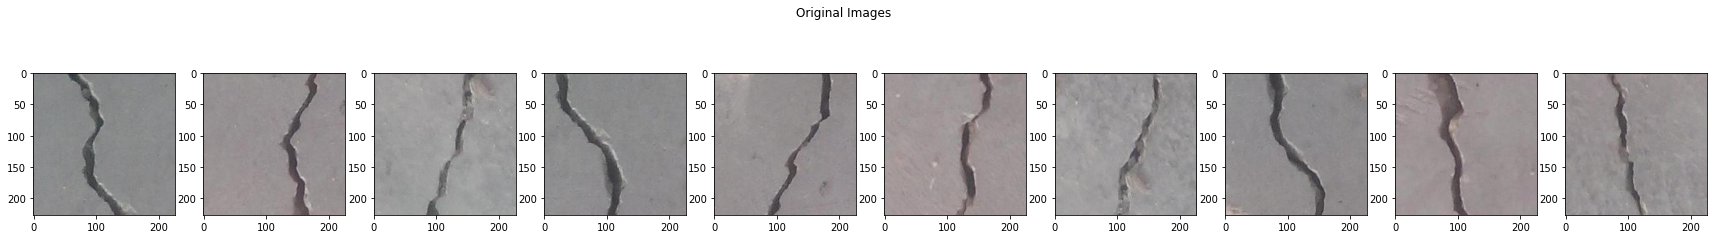

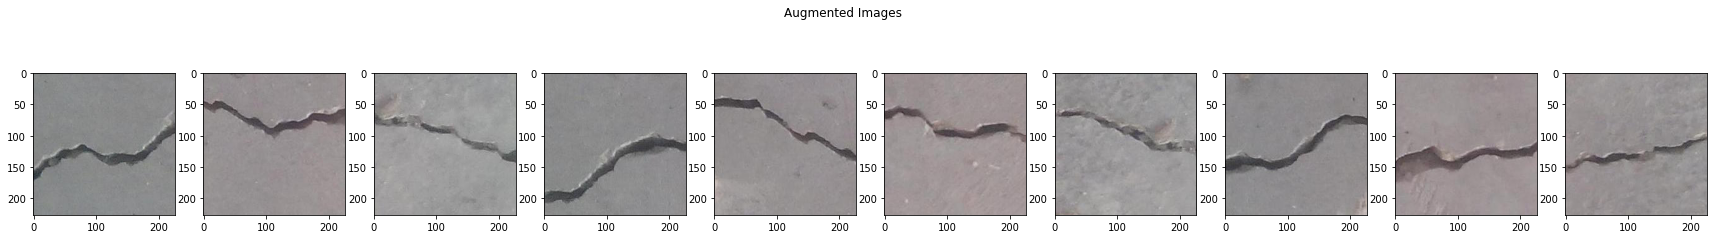

In [30]:
training_images = sorted(os.listdir('training/positive'))[0:]

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = 0
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Original Images') 
plt.show()

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 4)) 
index = int(len(training_images)/2)
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Augmented Images')
plt.show()

**Re-run CNN model using augmented images and test its performance**

In [31]:
cnn1_augmented1_fit_history = cnn1.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(cnn1)


640/640 [==============================] - 152s 237ms/step - loss: 0.6935 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4973
['negative', 'positive']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decks:
 [[    0 11595]
 [    0  2025]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     11595
    positive       0.15      1.00      0.26      2025

    accuracy                           0.15     13620
   macro avg       0.07      0.50      0.13     13620
weighted avg       0.02      0.15      0.04     13620

Pavements:
 [[    0 21726]
 [    0  2608]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     21726
    positive       0.11      1.00      0.19      2608

    accuracy                           0.11     24334
   macro avg       0.05      0.50      0.10     24334
weighted avg       0.01      0.11      0.02     24334

Walls:
 [[    0 14287]
 [    0  3851]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     14287
    positive       0.21      1.00      0.35      3851

    accuracy                           0.21     18138
 

**Re-run VGG16 model using augmented images and test its performance**

In [32]:
vgg16_augmented1_fit_history = vgg16.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(vgg16)

640/640 [==============================] - 365s 570ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.0095 - val_accuracy: 0.9974
['negative', 'positive']
Decks:
 [[10501  1094]
 [ 1855   170]] 
               precision    recall  f1-score   support

    negative       0.85      0.91      0.88     11595
    positive       0.13      0.08      0.10      2025

    accuracy                           0.78     13620
   macro avg       0.49      0.49      0.49     13620
weighted avg       0.74      0.78      0.76     13620

Pavements:
 [[17718  4008]
 [ 2082   526]] 
               precision    recall  f1-score   support

    negative       0.89      0.82      0.85     21726
    positive       0.12      0.20      0.15      2608

    accuracy                           0.75     24334
   macro avg       0.51      0.51      0.50     24334
weighted avg       0.81      0.75      0.78     24334

Walls:
 [[13311   976]
 [ 3602   249]] 
               precision    recall  f1-score   support

    

**Re-run ResNet50 model using augmented images (90 degree rotation) and test its performance**

In [33]:

resnet_augmented_fit_history = resnet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(resnet)


640/640 [==============================] - 270s 422ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0058 - val_accuracy: 0.9986
['negative', 'positive']
Decks:
 [[10743   852]
 [ 1867   158]] 
               precision    recall  f1-score   support

    negative       0.85      0.93      0.89     11595
    positive       0.16      0.08      0.10      2025

    accuracy                           0.80     13620
   macro avg       0.50      0.50      0.50     13620
weighted avg       0.75      0.80      0.77     13620

Pavements:
 [[18013  3713]
 [ 2107   501]] 
               precision    recall  f1-score   support

    negative       0.90      0.83      0.86     21726
    positive       0.12      0.19      0.15      2608

    accuracy                           0.76     24334
   macro avg       0.51      0.51      0.50     24334
weighted avg       0.81      0.76      0.78     24334

Walls:
 [[13443   844]
 [ 3622   229]] 
               precision    recall  f1-score   support

    

**Re-run RNN model using augmented images and test its performance**

## Horizontal Flip Augmentation ##

In [34]:

add_augmented_images(2) # horizonal flip

print("Training set:")
train_data = create_data_generator_set(root_directory+'/training', training_batch_size)


Training set:
Found 63996 images belonging to 2 classes.


Visualizing the Augmented Images: 

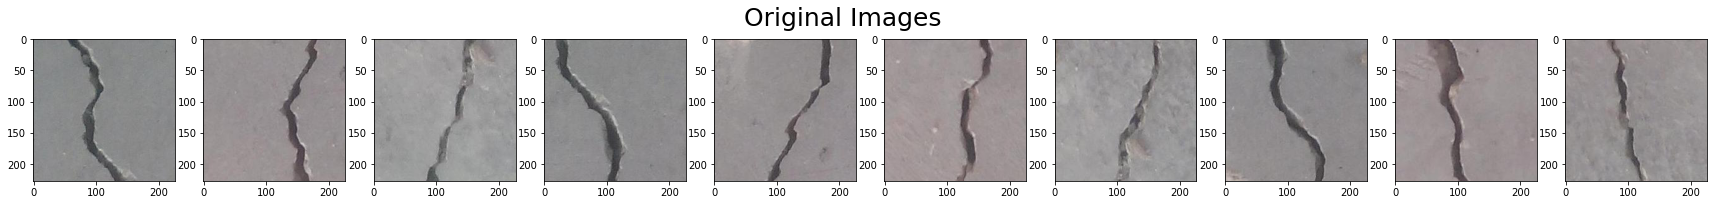

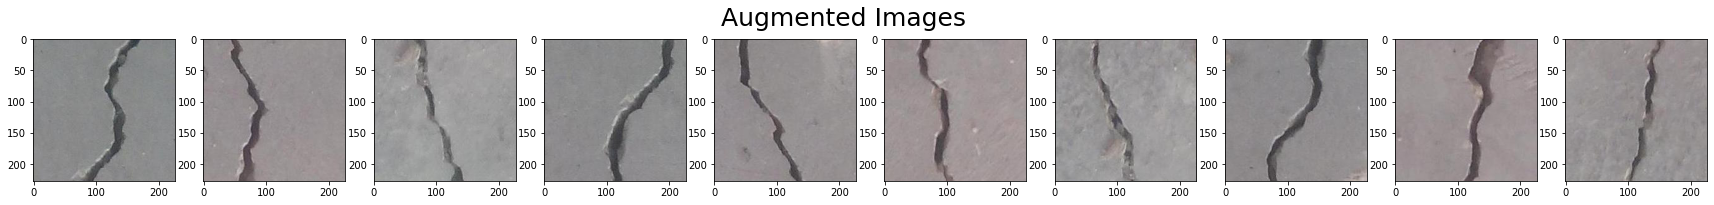

In [35]:

training_images = sorted(os.listdir('training/positive'))[0:]

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 3)) 
index = 0
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Original Images', fontsize=25) 
plt.show()

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 3)) 
index = int(len(training_images)/2)
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Augmented Images', fontsize=25) 
plt.show()



Rerun CNN with horizontal flip data augmentation

In [36]:

cnn3_augmented_fit_history = cnn1.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(cnn1)



640/640 [==============================] - 147s 230ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6932 - val_accuracy: 0.4973
['negative', 'positive']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decks:
 [[    0 11595]
 [    0  2025]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     11595
    positive       0.15      1.00      0.26      2025

    accuracy                           0.15     13620
   macro avg       0.07      0.50      0.13     13620
weighted avg       0.02      0.15      0.04     13620

Pavements:
 [[    0 21726]
 [    0  2608]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     21726
    positive       0.11      1.00      0.19      2608

    accuracy                           0.11     24334
   macro avg       0.05      0.50      0.10     24334
weighted avg       0.01      0.11      0.02     24334

Walls:
 [[    0 14287]
 [    0  3851]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     14287
    positive       0.21      1.00      0.35      3851

    accuracy                           0.21     18138
 

Rerun Resnet50 with flip data augmentation

In [37]:

resnet_augmented_fit_history = resnet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(resnet)



640/640 [==============================] - 269s 421ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0054 - val_accuracy: 0.9988
['negative', 'positive']
Decks:
 [[10822   773]
 [ 1907   118]] 
               precision    recall  f1-score   support

    negative       0.85      0.93      0.89     11595
    positive       0.13      0.06      0.08      2025

    accuracy                           0.80     13620
   macro avg       0.49      0.50      0.49     13620
weighted avg       0.74      0.80      0.77     13620

Pavements:
 [[18682  3044]
 [ 2266   342]] 
               precision    recall  f1-score   support

    negative       0.89      0.86      0.88     21726
    positive       0.10      0.13      0.11      2608

    accuracy                           0.78     24334
   macro avg       0.50      0.50      0.49     24334
weighted avg       0.81      0.78      0.79     24334

Walls:
 [[13605   682]
 [ 3702   149]] 
               precision    recall  f1-score   support

    

Vertical Flip data augmentation

In [38]:

add_augmented_images(3) # vertical flip

print("Training set:")
train_data = create_data_generator_set(root_directory+'/training', training_batch_size)


Training set:
Found 63996 images belonging to 2 classes.


Visualization of data augmentation

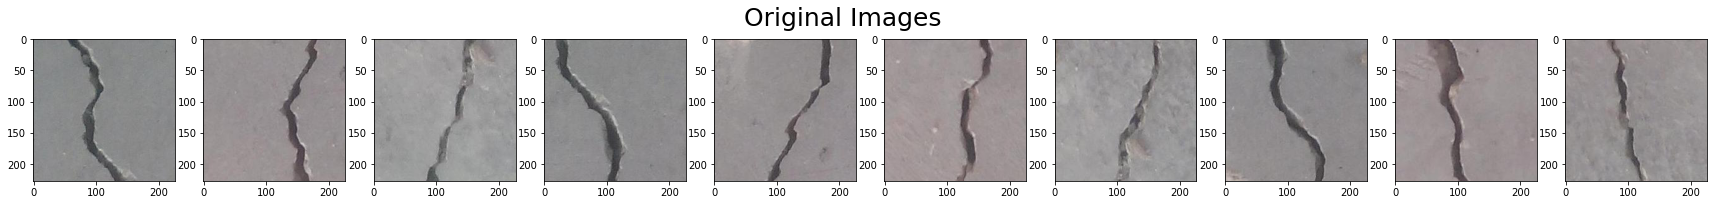

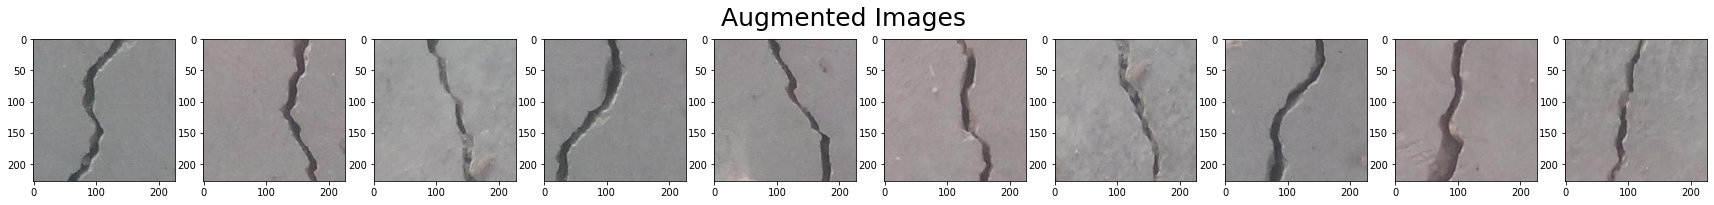

In [39]:

training_images = sorted(os.listdir('training/positive'))[0:]

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 3)) 
index = 0
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Original Images', fontsize=25)  
plt.show()

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 3)) 
index = int(len(training_images)/2)
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Augmented Images', fontsize=25) 
plt.show()



Rerun models with vertical augmentation

In [45]:

#CNN: 
cnn3_augmented_fit_history = cnn1.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(cnn1)


640/640 [==============================] - 151s 236ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4973
['negative', 'positive']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decks:
 [[    0 11595]
 [    0  2025]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     11595
    positive       0.15      1.00      0.26      2025

    accuracy                           0.15     13620
   macro avg       0.07      0.50      0.13     13620
weighted avg       0.02      0.15      0.04     13620

Pavements:
 [[    0 21726]
 [    0  2608]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     21726
    positive       0.11      1.00      0.19      2608

    accuracy                           0.11     24334
   macro avg       0.05      0.50      0.10     24334
weighted avg       0.01      0.11      0.02     24334

Walls:
 [[    0 14287]
 [    0  3851]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     14287
    positive       0.21      1.00      0.35      3851

    accuracy                           0.21     18138
 

In [46]:

resnet_augmented_fit_history = resnet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(resnet)



640/640 [==============================] - 255s 398ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0074 - val_accuracy: 0.9984
['negative', 'positive']
Decks:
 [[10525  1070]
 [ 1835   190]] 
               precision    recall  f1-score   support

    negative       0.85      0.91      0.88     11595
    positive       0.15      0.09      0.12      2025

    accuracy                           0.79     13620
   macro avg       0.50      0.50      0.50     13620
weighted avg       0.75      0.79      0.77     13620

Pavements:
 [[17448  4278]
 [ 2083   525]] 
               precision    recall  f1-score   support

    negative       0.89      0.80      0.85     21726
    positive       0.11      0.20      0.14      2608

    accuracy                           0.74     24334
   macro avg       0.50      0.50      0.49     24334
weighted avg       0.81      0.74      0.77     24334

Walls:
 [[12993  1294]
 [ 3513   338]] 
               precision    recall  f1-score   support

    

## Vertical flip augmentation 

In [47]:

add_augmented_images(3) # vertical flip

print("Training set:")
train_data = create_data_generator_set(root_directory+'/training', training_batch_size)



Training set:
Found 63996 images belonging to 2 classes.


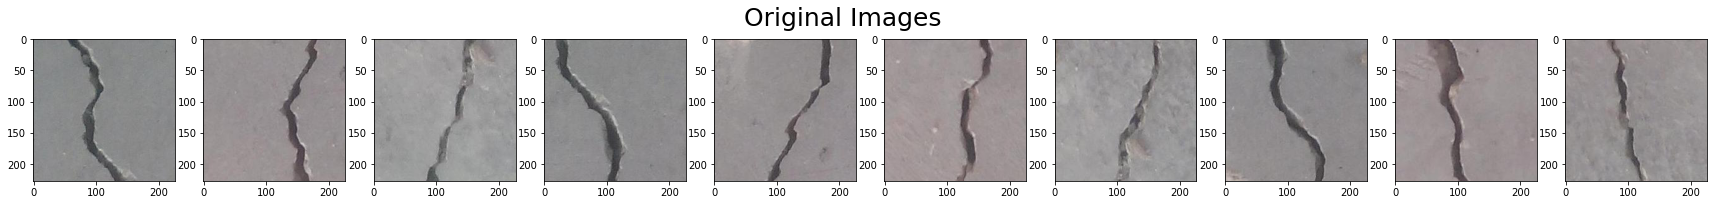

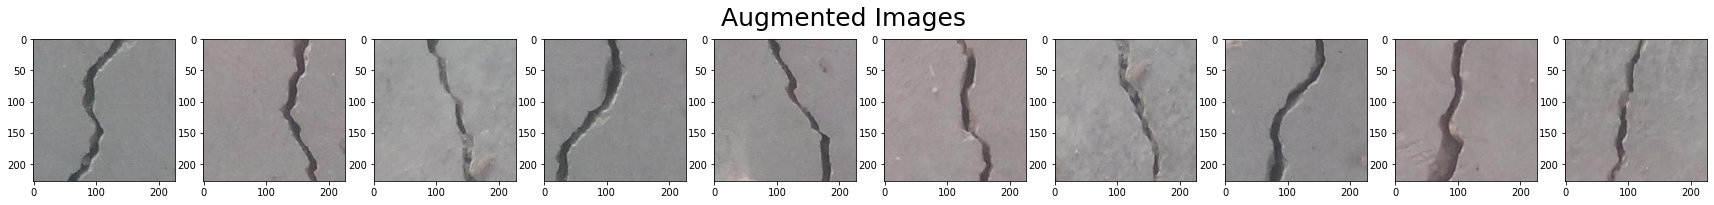

In [48]:

training_images = sorted(os.listdir('training/positive'))[0:]

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 3)) 
index = 0
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Original Images', fontsize=25)  
plt.show()

figure, position = plt.subplots(nrows=1, ncols=10, figsize=(30, 3)) 
index = int(len(training_images)/2)
for current_position in position:
    current_position.imshow(Image.open(f'training/positive/{training_images[index]}'))
    index = index + 1
figure.suptitle('Augmented Images', fontsize=25) 
plt.show()





```
# This is formatted as code
```

**Re-run CNN 3 and RESNET model using augmented images (vertical flip) and test its performance**

In [49]:
cnn3_augmented_fit_history = cnn1.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(cnn1)

640/640 [==============================] - 150s 234ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4973
['negative', 'positive']


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decks:
 [[    0 11595]
 [    0  2025]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     11595
    positive       0.15      1.00      0.26      2025

    accuracy                           0.15     13620
   macro avg       0.07      0.50      0.13     13620
weighted avg       0.02      0.15      0.04     13620

Pavements:
 [[    0 21726]
 [    0  2608]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     21726
    positive       0.11      1.00      0.19      2608

    accuracy                           0.11     24334
   macro avg       0.05      0.50      0.10     24334
weighted avg       0.01      0.11      0.02     24334

Walls:
 [[    0 14287]
 [    0  3851]] 
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00     14287
    positive       0.21      1.00      0.35      3851

    accuracy                           0.21     18138
 

In [50]:
resnet_augmented_fit_history = resnet.fit(train_data, steps_per_epoch=len(train_data), epochs=num_epochs,
    validation_data=validation_data, validation_steps=len(validation_data), verbose=1)
model_testing_three_datasets(resnet)

640/640 [==============================] - 256s 400ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0070 - val_accuracy: 0.9973
['negative', 'positive']
Decks:
 [[10989   606]
 [ 1936    89]] 
               precision    recall  f1-score   support

    negative       0.85      0.95      0.90     11595
    positive       0.13      0.04      0.07      2025

    accuracy                           0.81     13620
   macro avg       0.49      0.50      0.48     13620
weighted avg       0.74      0.81      0.77     13620

Pavements:
 [[19329  2397]
 [ 2336   272]] 
               precision    recall  f1-score   support

    negative       0.89      0.89      0.89     21726
    positive       0.10      0.10      0.10      2608

    accuracy                           0.81     24334
   macro avg       0.50      0.50      0.50     24334
weighted avg       0.81      0.81      0.81     24334

Walls:
 [[13971   316]
 [ 3766    85]] 
               precision    recall  f1-score   support

    